In [117]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [343]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [3]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), (str(id(n2)) + n2._op))

    return dot

In [82]:
import torch

In [84]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();  w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True
b  = torch.Tensor([6.7]).double();  b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.6043676560501806
----
x2 0.6347397363204106
w2 0.0
x1 -1.9042192089612318
w1 1.2694794726408212


In [83]:
torch.Tensor([[1,2,3], [4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [85]:
import random

In [323]:

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for (wi, xi) in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [328]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8168473131045729)

In [344]:
n = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]


0 1.4115780356331397e-05
1 1.4115037812042478e-05
2 1.4114295346891736e-05
3 1.411355296086692e-05
4 1.411281065395478e-05
5 1.4112068426143703e-05
6 1.4111326277421038e-05
7 1.4110584207773787e-05
8 1.4109842217190752e-05
9 1.410910030565727e-05
10 1.4108358473162507e-05
11 1.4107616719693574e-05
12 1.4106875045238312e-05
13 1.4106133449782981e-05
14 1.410539193331666e-05
15 1.410465049582525e-05
16 1.41039091372978e-05
17 1.4103167857721452e-05
18 1.410242665708286e-05
19 1.4101685535371347e-05


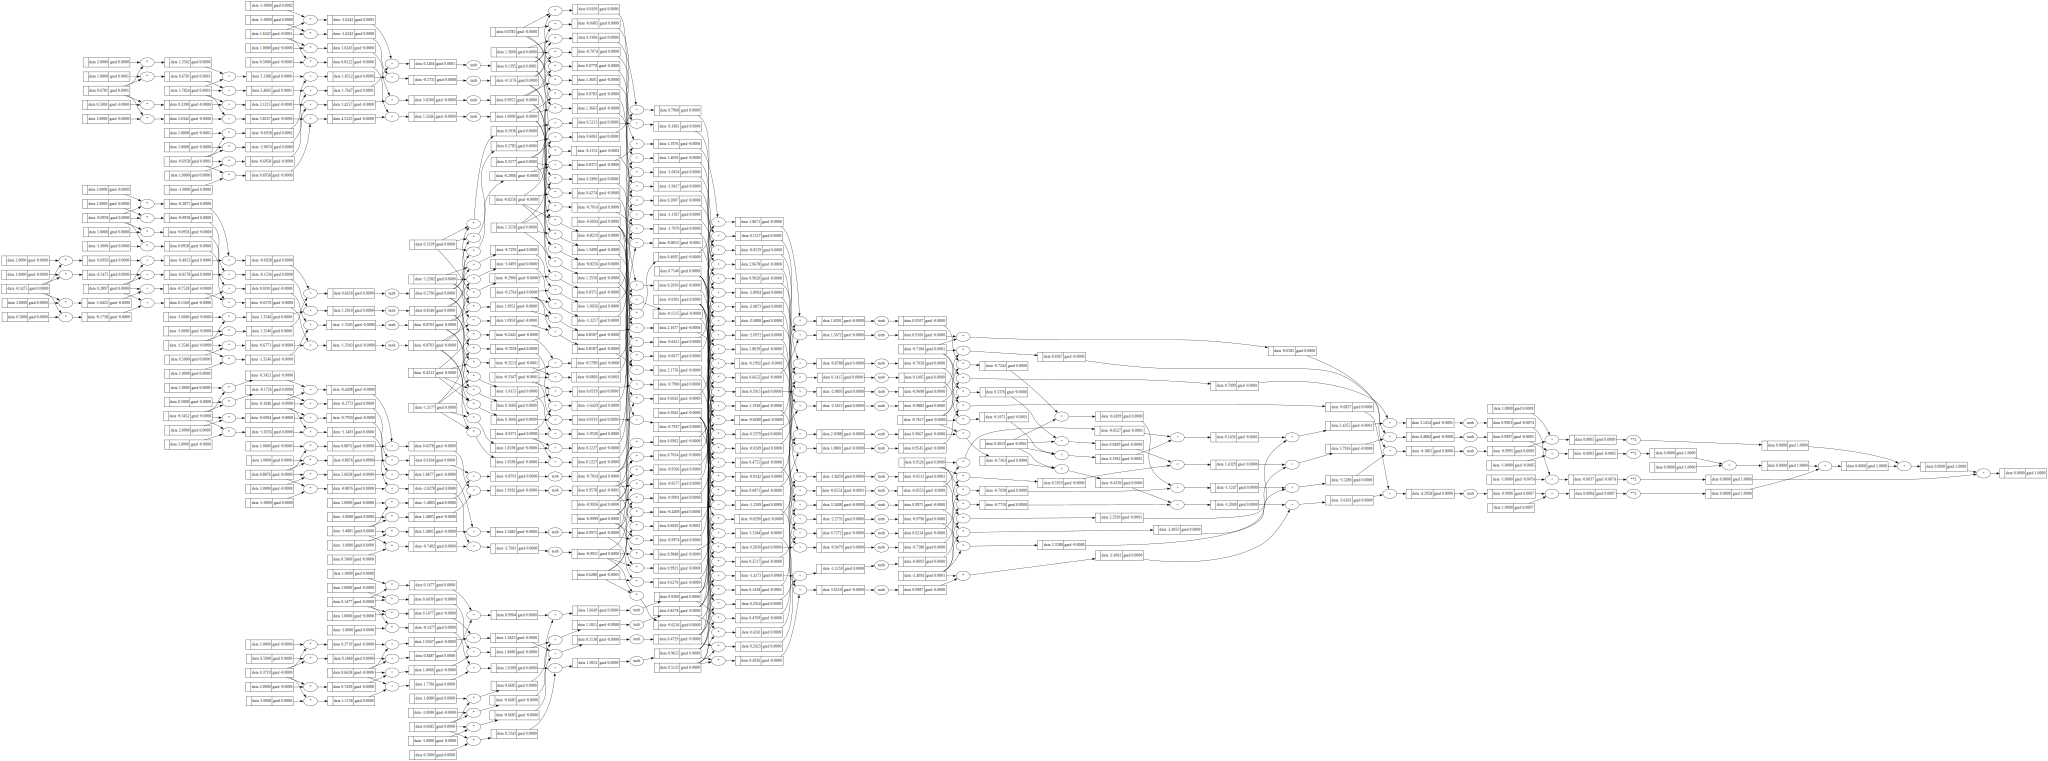

In [347]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

draw_dot(loss)


In [348]:
ypred

[Value(data=0.9997473989289969),
 Value(data=-0.9996287574949796),
 Value(data=-0.9995380501418312),
 Value(data=0.9963004514376341)]

In [339]:
len(n.parameters())

41